# Aligning images of apples using OpenCV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils

#to import pictures as numpy
import PIL
from PIL import Image

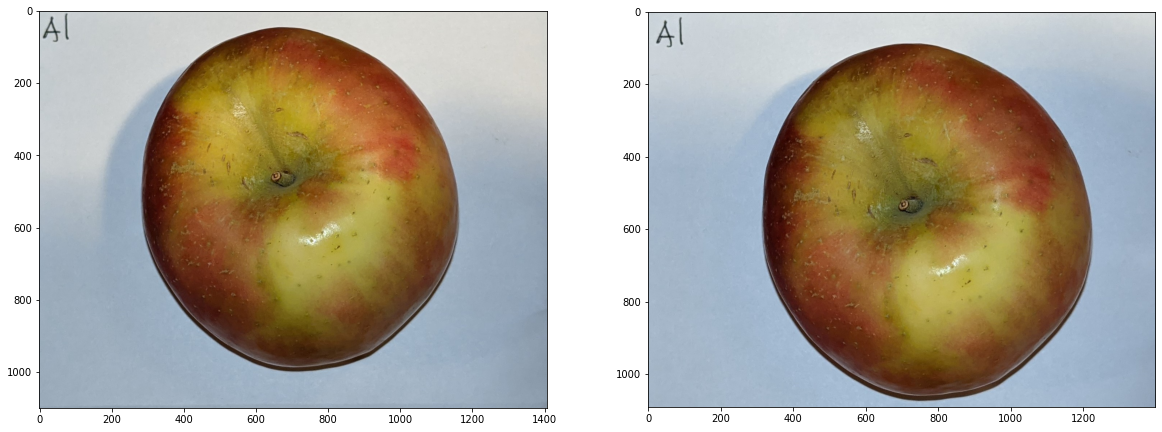

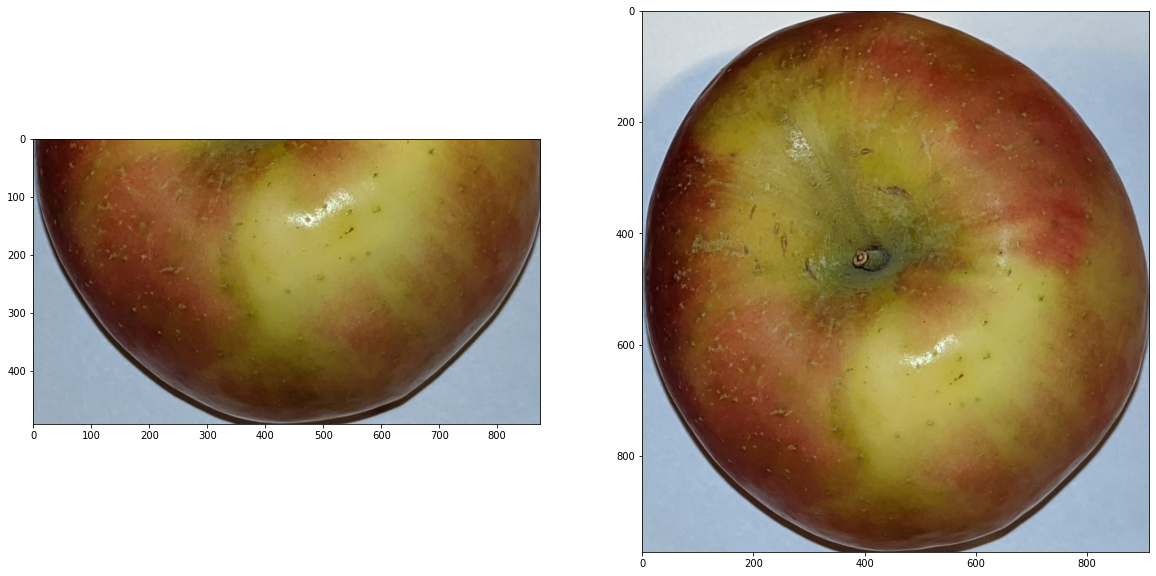

In [2]:
experiment_image_dir = 'data/J/experiment1/pic/'
a1t1 = cv2.imread(experiment_image_dir + 't1/a1t1.jpg')
a1t2 = cv2.imread(experiment_image_dir + 't2/a1t2.jpg')

def crop_apple(image, min_dim_size=400):
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(image, 100, 250, apertureSize=3)
    cv2.imshow("Matched Keypoints", edged)
    (cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mx,my,mw,mh=0,0,0,0
    msum=0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w+h > msum:
            msum = w+h
            mx,my,mw,mh=x,y,w,h
    if msum == 0:
        raise RuntimeException("Could not find appple!")
    new_img=image[my:my+mh,mx:mx+mw] 
    return new_img
        
def display_image_pair(img1, img2):
    (fig, ax) = plt.subplots(1, 2, figsize=(20,20))
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

c_1 = crop_apple(a1t1)
c_2 = crop_apple(a1t2)
display_image_pair(a1t1, a1t2)
display_image_pair(c_1, c_2)

### step 1, grayscale

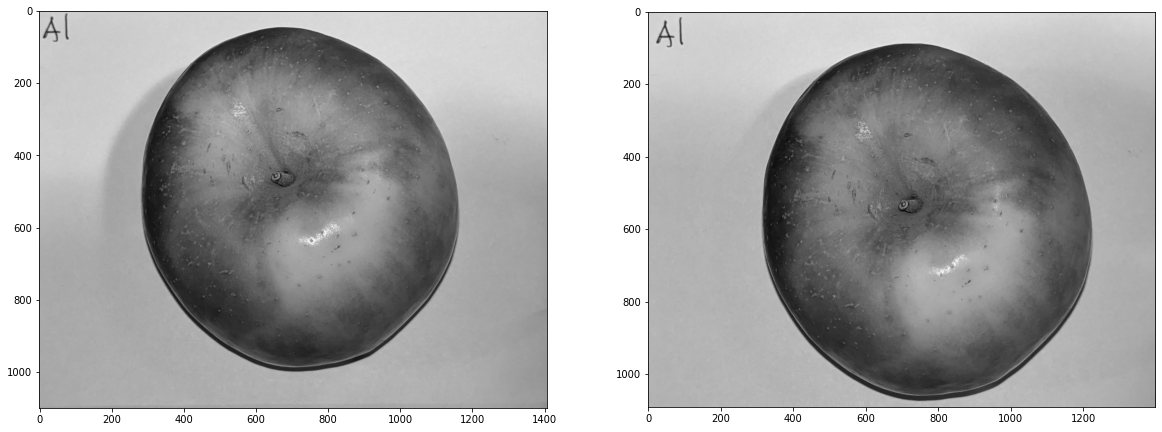

In [3]:
gr_a1t1 = cv2.cvtColor(a1t1, cv2.COLOR_BGR2GRAY)
gr_a1t2 = cv2.cvtColor(a1t2, cv2.COLOR_BGR2GRAY)

display_image_pair(gr_a1t1, gr_a1t2)

In [4]:
# use ORB to detect keypoints and extract (binary) localgit@github.prod.oc.2u.com:jtrobec/w241-ps4-fall2020-section5.git
# invariant features
orb = cv2.ORB_create(500)
(kpsA, descsA) = orb.detectAndCompute(gr_a1t1, None)
(kpsB, descsB) = orb.detectAndCompute(gr_a1t2, None)
    
# match the features
method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
matcher = cv2.DescriptorMatcher_create(method)
matches = matcher.match(descsA, descsB, None)

In [5]:
# sort the matches by their distance (the smaller the distance,
# the "more similar" the features are)
matches = sorted(matches, key=lambda x:x.distance)
# keep only the top matches
keep = int(len(matches) * 0.25)
matches = matches[:keep]
# check to see if we should visualize the matched keypoints
matchedVis = cv2.drawMatches(a1t1, kpsA, a1t2, kpsB,
            matches, None)
matchedVis = imutils.resize(matchedVis, width=1000)
cv2.imshow("Matched Keypoints", matchedVis)
cv2.waitKey(0)

-1

In [6]:
# allocate memory for the keypoints (x, y)-coordinates from the
# top matches -- we'll use these coordinates to compute our
# homography matrix
ptsA = np.zeros((len(matches), 2), dtype="float")
ptsB = np.zeros((len(matches), 2), dtype="float")
# loop over the top matches
for (i, m) in enumerate(matches):
    # indicate that the two keypoints in the respective images
    # map to each other
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt

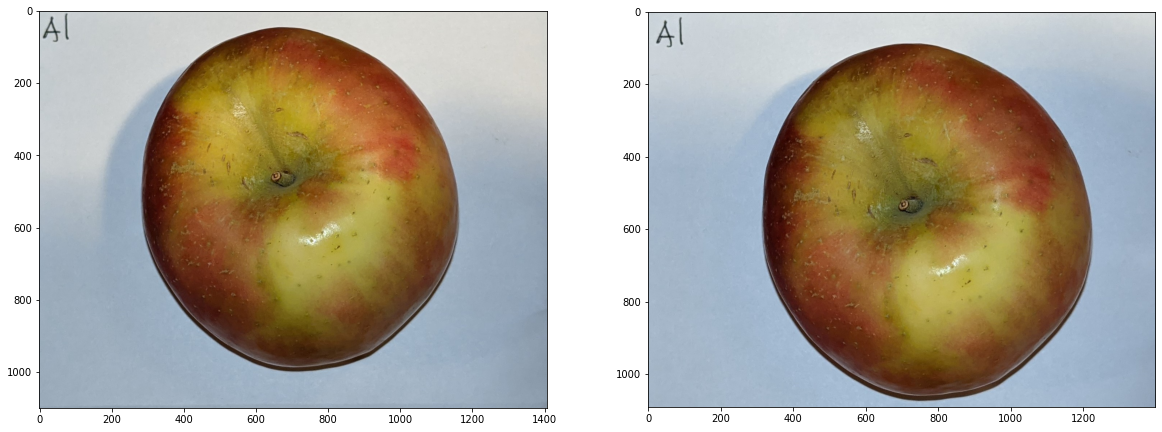

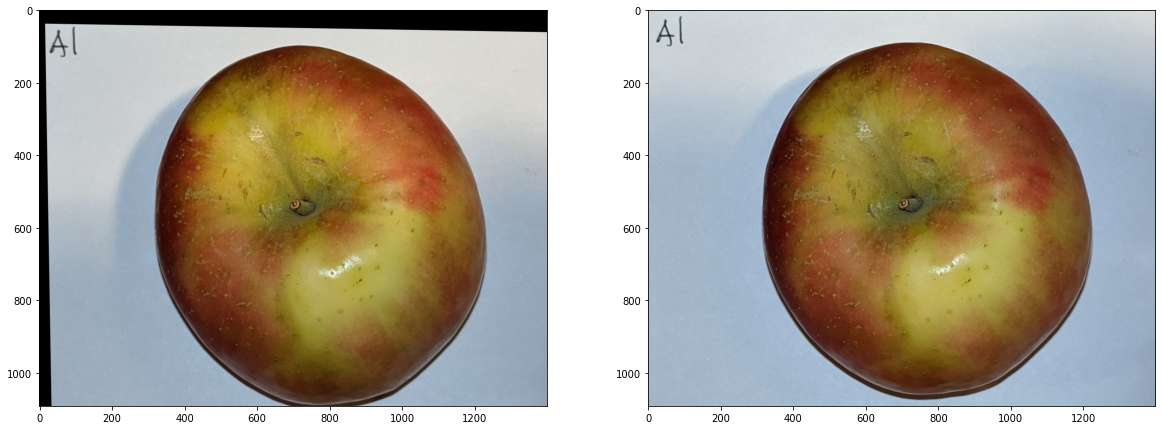

In [7]:
# compute the homography matrix between the two sets of matched
# points
(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
# use the homography matrix to align the images
(h, w) = a1t2.shape[:2]
aligned = cv2.warpPerspective(a1t1, H, (w, h))
# return the aligned image
display_image_pair(a1t1, a1t2)
display_image_pair(aligned, a1t2)

In [8]:
len(matches)

125

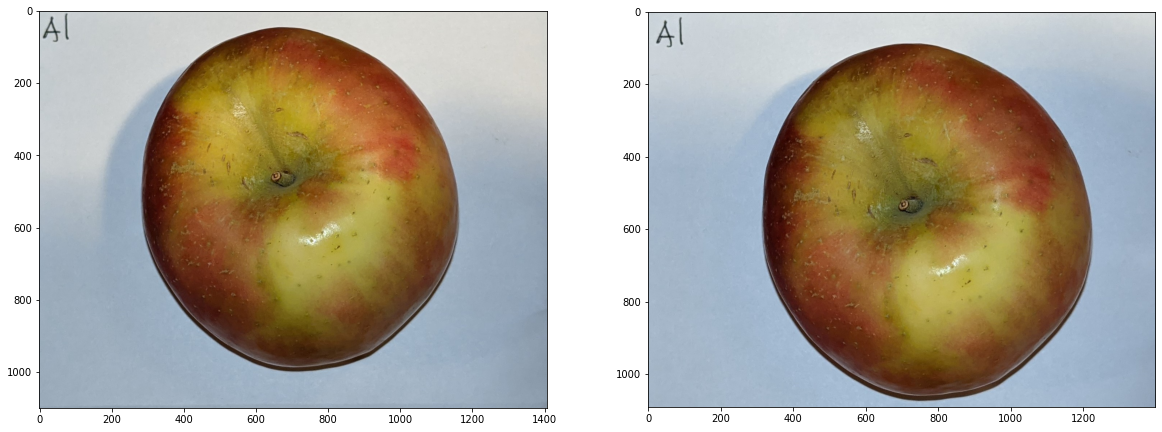

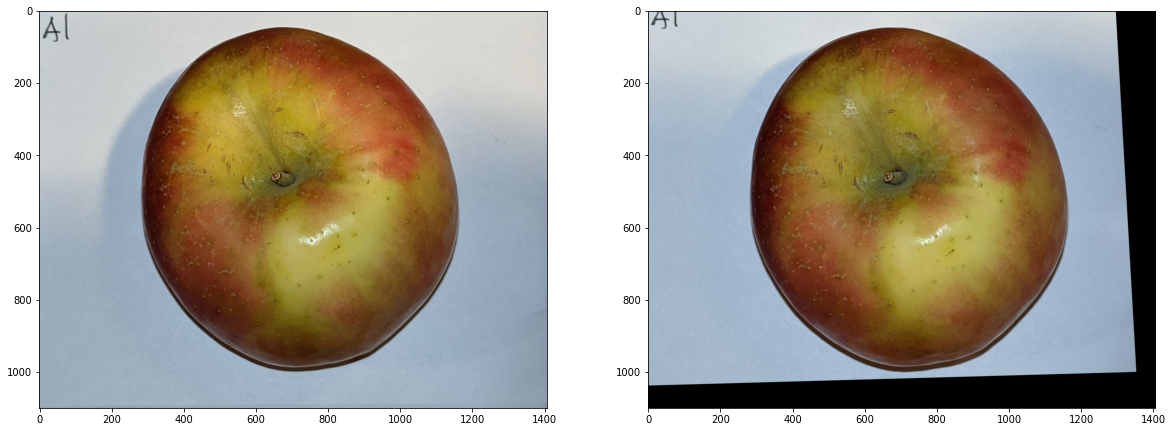

In [9]:
# Find size of image1
sz = a1t1.shape
# Define the motion model
warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrix = np.eye(3, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 5000;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;
 
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC(gr_a1t1, gr_a1t2, warp_matrix, warp_mode, criteria, inputMask=None, gaussFiltSize=1)
 
im2_aligned = cv2.warpPerspective(a1t2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

# Show final results
display_image_pair(a1t1, a1t2)
display_image_pair(a1t1, im2_aligned)